# Generating Images to Fool an MNIST Classifier

Despite their high performance on classification tasks such as MNIST, neural networks like the [LeNet-5](https://en.wikipedia.org/wiki/LeNet) have a weakness: they are easy to fool. Namely, given images like the ones below, a classifier may confidently believe that it is seeing certain digits, even though the images look like random noise to humans. Naturally, this phenomenon raises some concerns, especially when the network in question is used in a safety-critical system like a self-driving car. Given such unrecognizable input, one would hope that the network at least has low confidence in its prediction.

![fooling images example](_static/fooling_mnist_example.png)

To make matters worse for neural networks, generating such images is incredibly easy with QD algorithms. As shown in [Nguyen 2015](http://anhnguyen.me/project/fooling/), one can use simple MAP-Elites to generate these images. In this tutorial, we will instead use the pyribs version of MAP-Elites to do just that.

## Setup

First, we install pyribs and PyTorch.

In [ ]:
%pip install ribs torch torchvision

Here, we import PyTorch and some utilities.

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

Below, we check what device is available for PyTorch. On Colab, activate the GPU by clicking "Runtime" in the toolbar at the top. Then, click "Change Runtime Type", and select "GPU".

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Preliminary: MNIST Network

For the classifier network, we train a LeNet-5 to classify MNIST. If you are not familiar with PyTorch, we recommend referring to the [PyTorch 60-minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). On the other hand, if you are familiar, feel free to skip to the next section, where we demonstrate how to fool the network.

**Note**: This section is adapted from the [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) tutorial in the 60-minute blitz.

Before training the network, we load and preprocess the MNIST dataset.

In [4]:
# Transform each image by turning it into a tensor and then
# normalizing the values.
MEAN_TRANSFORM = 0.1307
STD_DEV_TRANSFORM = 0.3081
mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((MEAN_TRANSFORM,), (STD_DEV_TRANSFORM,))
])

TRAIN_BATCH_SIZE = 64
TRAINLOADER = torch.utils.data.DataLoader(torchvision.datasets.MNIST(
    './data', train=True, download=True, transform=mnist_transforms),
                                          batch_size=TRAIN_BATCH_SIZE,
                                          shuffle=True)

TEST_BATCH_SIZE = 1000
TESTLOADER = torch.utils.data.DataLoader(torchvision.datasets.MNIST(
    './data', train=False, transform=mnist_transforms),
                                         batch_size=TEST_BATCH_SIZE,
                                         shuffle=False)

This is our training function. We use negative log likelihood loss and Adam optimization.

In [5]:
def fit(net, epochs):
    """Trains net for the given number of epochs."""
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        print(f"=== Epoch {epoch + 1} ===")
        total_loss = 0.0

        # Iterate through batches in the shuffled training dataset.
        for batch_i, data in enumerate(TRAINLOADER):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if (batch_i + 1) % 100 == 0:
                print(f"Batch {batch_i + 1:5d}: {total_loss}")
                total_loss = 0.0

Now, we define the LeNet-5 and train it for 2 epochs. We have annotated the shapes of the data (excluding the batch dimension) as they pass through the network.

In [6]:
LENET5 = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), stride=1, padding=0),  # (1,28,28) -> (6,24,24)
    nn.MaxPool2d(2),  # (6,24,24) -> (6,12,12)
    nn.ReLU(),
    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),  # (6,12,12) -> (16,8,8)
    nn.MaxPool2d(2),  # (16,8,8) -> (16,4,4)
    nn.ReLU(),
    nn.Flatten(),  # (16,4,4) -> (256,)
    nn.Linear(256, 120),  # (256,) -> (120,)
    nn.ReLU(),
    nn.Linear(120, 84),  # (120,) -> (84,)
    nn.ReLU(),
    nn.Linear(84, 10),  # (84,) -> (10,)
    nn.LogSoftmax(dim=1),  # (10,) log probabilities
).to(device)

fit(LENET5, 2)

=== Epoch 1 ===
Batch   100: 103.92088487744331
Batch   200: 33.70535735785961
Batch   300: 22.15521464496851
Batch   400: 17.821983620524406
Batch   500: 15.65167298913002
Batch   600: 13.086637169122696
Batch   700: 12.409602331928909
Batch   800: 10.96252972073853
Batch   900: 9.360629732720554
=== Epoch 2 ===
Batch   100: 7.9545784797519445
Batch   200: 8.44696637801826
Batch   300: 7.563114176504314
Batch   400: 8.443509192671627
Batch   500: 6.890517502557486
Batch   600: 7.3185144872404635
Batch   700: 7.459332271013409
Batch   800: 5.568579972721636
Batch   900: 6.198564644902945


Finally, we evaluate the network on the train and test sets.

In [7]:
def evaluate(net, loader):
    """Evaluates the network's accuracy on the images in the dataloader."""
    correct_per_num = [0 for _ in range(10)]
    total_per_num = [0 for _ in range(10)]

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.to("cpu"), 1)
            c = (predicted == labels).squeeze()
            for i in range(len(c)):
                label = labels[i]
                correct_per_num[label] += c[i].item()
                total_per_num[label] += 1

    for i in range(10):
        print(f"Class {i}: {correct_per_num[i] / total_per_num[i]:5.3f}"
              f" ({correct_per_num[i]} / {total_per_num[i]})")
    print(f"TOTAL  : {sum(correct_per_num) / sum(total_per_num):5.3f}"
          f" ({sum(correct_per_num)} / {sum(total_per_num)})")

In [8]:
evaluate(LENET5, TRAINLOADER)

Class 0: 0.987 (5847 / 5923)
Class 1: 0.994 (6703 / 6742)
Class 2: 0.982 (5852 / 5958)
Class 3: 0.988 (6058 / 6131)
Class 4: 0.990 (5781 / 5842)
Class 5: 0.981 (5316 / 5421)
Class 6: 0.996 (5895 / 5918)
Class 7: 0.969 (6068 / 6265)
Class 8: 0.969 (5672 / 5851)
Class 9: 0.985 (5861 / 5949)
TOTAL  : 0.984 (59053 / 60000)


In [9]:
evaluate(LENET5, TESTLOADER)

Class 0: 0.988 (968 / 980)
Class 1: 0.996 (1130 / 1135)
Class 2: 0.976 (1007 / 1032)
Class 3: 0.989 (999 / 1010)
Class 4: 0.991 (973 / 982)
Class 5: 0.983 (877 / 892)
Class 6: 0.991 (949 / 958)
Class 7: 0.966 (993 / 1028)
Class 8: 0.975 (950 / 974)
Class 9: 0.984 (993 / 1009)
TOTAL  : 0.984 (9839 / 10000)


## Fooling the Classifier with MAP-Elites

Above, we trained a reasonably high-performing classifier. In order to fool the classifier into seeing various digits, we use MAP-Elites. As we have 10 distinct digits (0-9), we have a discrete behavior space with 10 values. Note that while pyribs is designed for continuous search spaces, the behavior space can be either continuous or discrete.

Our classifier outputs a log probability vector with its belief that it is seeing each digit. Thus, our objective for each digit is to maximize the probability that the classifier assigns to the image associated with it. For instance, for digit 5, we want to generate an image that makes the classifier believe with high probability that it is seeing a 5.

In pyribs, we implement MAP-Elites with a `GridArchive` and a `GaussianEmitter`. Below, we start by constructing the `GridArchive`. The archive has 10 bins and a range of (0,10). Since `GridArchive` was originally designed for continuous spaces, it does not directly support discrete spaces, but by using these settings, we have a bin for each digit from 0 to 9.

In [10]:
from ribs.archives import GridArchive

archive = GridArchive([10], [(0, 10)])

Next, we use 5 Gaussian emitters, each with batch size of 30. Each emitter begins with an image filled with 0.5 (i.e. grey, since pixels are in the range $[0,1]$) and has $\sigma = 0.5$.

In [11]:
from ribs.emitters import GaussianEmitter

img_size = (28, 28)
flat_img_size = 784  # 28 * 28
emitters = [
    GaussianEmitter(
        archive,
        # Start with a grey image.
        np.full(flat_img_size, 0.5),
        0.5,
        # Bound the generated images to the pixel range.
        bounds=[(0, 1)] * flat_img_size,
        batch_size=30,
    ) for _ in range(5)
]

Finally, we construct the optimizer to connect the archive and emitters together.

In [12]:
from ribs.optimizers import Optimizer

optimizer = Optimizer(archive, emitters)

With the components created, we now generate the images. As we use 5 emitters each with batch size of 30 and run 6,000 iterations, we evaluate 900,000 images in total.

In [13]:
total_itrs = 6000
start_time = time.time()

for itr in range(1, total_itrs + 1):
    sols = optimizer.ask()

    with torch.no_grad():

        # Reshape and normalize the image and pass it through the network.
        imgs = sols.reshape((-1, 1, *img_size))
        imgs = (imgs - MEAN_TRANSFORM) / STD_DEV_TRANSFORM
        imgs = torch.tensor(imgs, dtype=torch.float32, device=device)
        output = LENET5(imgs)

        # The BC is the digit that the network believes it is seeing, i.e. the
        # digit with the maximum probability. The objective is the probability
        # associated with that digit.
        scores, predicted = torch.max(output.to("cpu"), 1)
        scores = torch.exp(scores)
        objs = scores.numpy()
        bcs = predicted.numpy()

    optimizer.tell(objs, bcs)
    
    if itr % 500 == 0:
        print(f"Iteration {itr} complete after {time.time() - start_time} s")

Iteration 500 complete after 11.317359447479248 s
Iteration 1000 complete after 20.381446361541748 s
Iteration 1500 complete after 29.439425468444824 s
Iteration 2000 complete after 38.70516514778137 s
Iteration 2500 complete after 48.32654023170471 s
Iteration 3000 complete after 57.88940477371216 s
Iteration 3500 complete after 67.32674074172974 s
Iteration 4000 complete after 77.77149820327759 s
Iteration 4500 complete after 89.96416592597961 s
Iteration 5000 complete after 99.85577702522278 s
Iteration 5500 complete after 109.35589170455933 s
Iteration 6000 complete after 118.67683720588684 s


Below, we display the results we found with MAP-Elites. The `index_0` column shows the digit associated with each image, and the `objective` column shows the network's belief that the image is that digit. The `solution` columns show the image's pixel values.

In [14]:
archive.as_pandas().sort_values("index_0")

,index_0,behavior_0,objective,solution_0,solution_1,solution_2,solution_3,solution_4,solution_5,solution_6,...,solution_774,solution_775,solution_776,solution_777,solution_778,solution_779,solution_780,solution_781,solution_782,solution_783
1,0,0.0,0.929513,0.666185,0.094848,0.679688,0.000000,0.867709,0.558049,0.363775,...,0.564437,1.000000,0.671843,0.000000,0.142737,0.208487,1.000000,0.052058,0.209409,0.094693
2,2,2.0,0.986729,1.000000,0.685207,0.728273,0.680493,0.749196,0.868995,0.456220,...,0.000000,1.000000,0.918081,1.000000,1.000000,1.000000,0.530227,0.190481,0.000000,0.314496
3,3,3.0,0.992450,1.000000,0.483390,0.201991,0.000000,1.000000,1.000000,0.331929,...,0.712497,1.000000,0.000000,0.690873,0.932973,0.101159,0.742524,0.000000,0.567233,0.066197
4,4,4.0,0.995215,0.000000,0.969984,0.000000,0.612051,1.000000,0.000000,0.000000,...,0.000000,0.502019,0.210630,0.565360,0.391433,0.038559,0.772292,0.649052,0.193482,1.000000
8,5,5.0,0.958060,0.675056,1.000000,0.064789,0.000000,0.235084,1.000000,1.000000,...,0.000000,0.915055,0.699775,0.241711,0.000000,0.836332,0.000000,0.370514,0.714322,0.081487
5,6,6.0,0.968553,0.811132,0.395137,0.577237,0.269608,0.118688,0.289920,0.000000,...,1.000000,0.000000,0.083905,0.868328,0.298324,0.716925,0.736255,1.000000,0.000000,0.305833
7,7,7.0,0.970018,0.224700,0.768123,0.547491,0.783308,1.000000,0.590328,0.291507,...,0.000000,0.279329,1.000000,0.000000,1.000000,0.838454,0.563636,0.829742,1.000000,0.000000
0,8,8.0,0.998245,0.133900,0.443820,0.000000,0.000000,0.000000,1.000000,0.607856,...,1.000000,0.682026,1.000000,0.646690,0.861757,1.000000,0.354071,0.269678,0.502267,0.000000
6,9,9.0,0.957564,0.330562,1.000000,1.000000,0.093036,0.676963,0.985599,0.233686,...,0.031970,0.000000,0.117085,0.566163,0.081003,1.000000,0.967519,0.293034,0.000000,1.000000


Here, we display the images found. Interestingly, though the images look mostly like noise, we can occasionally make out traces of the original digit. Note that MAP-Elites may not find images for all the digits, and this is mostly due to the small behavior space. Usually, QD algorithms run with fairly large behavior spaces. This is something to keep in mind when tuning QD algorithms.

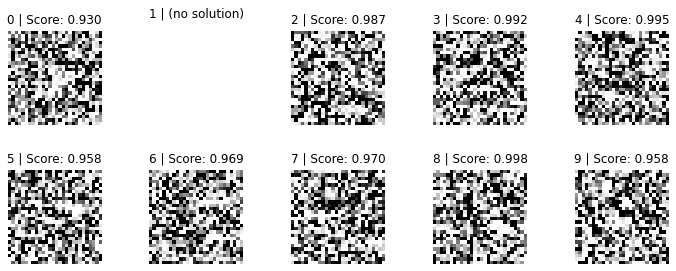

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
fig.tight_layout()
ax = ax.flatten()
found = set()

# Display images.
for _, row in archive.as_pandas().iterrows():
    i = int(row.loc["index_0"])
    found.add(i)
    obj = row.loc["objective"]
    ax[i].set_title(f"{i} | Score: {obj:.3f}", pad=8)
    img = row.loc["solution_0":].to_numpy().reshape(28, 28)

    # No need to normalize image because we want to see the original.
    ax[i].imshow(img, cmap="Greys")
    ax[i].set_axis_off()

# Mark digits that we did not generate images for.
for i in range(10):
    if i not in found:
        ax[i].set_title(f"{i} | (no solution)", pad=8)
        ax[i].set_axis_off()

## Conclusion

In this tutorial, we used MAP-Elites to generate images that fool a LeNet-5 MNIST classifier. For further exploration, we recommend referring to [Nguyen 2015](http://anhnguyen.me/project/fooling/) and replicating or extending the other experiments described in the paper.